# Entropic Estimation of optimal transport maps

This tutorial aim to present and implement the estimator depicted in \cite{PNW21}, using the `EntropicPotentials` class of OTT.

## Barycentric projection estimator

Let $P$ a source distribution and $Q$ a target distribution, $T_0$ is the optimal transport function between $P$ and $Q$. The proposed estimator solve the followed regularized optimal transport problem : 
$$ \underset{\pi \in \Pi(P,Q)}{\text{inf}} \iint_{}^{} \frac{1}{2}\left\|x-y\right\|_2^2 \text{d}\pi(x,y) + \varepsilon D_{KL}(\pi \| P \otimes Q)$$
or it dual version
$$ \underset{g \in \mathrm{L}^1(P)}{\underset{f \in \mathrm{L}^1(P)}{\text{sup}}} \int{}{} f \text{ d}P + \int{}{} g \text{ d}Q - \varepsilon \iint e^{(f(x)+g(y)- \frac{1}{2}\left\|x-y\right\|_2^2)/\varepsilon} \text{ d}P(x)\text{ d}Q(y) + \varepsilon$$

Let $\pi_\varepsilon$ the optimal transport plan and $(f_\varepsilon,g_\varepsilon)$ the optimal entropic potentials functions we can then define the barycentric projection of $\pi_\varepsilon$ 

$$ \mathrm{T}_\varepsilon(x) = \int y \text{ d}\pi^x_\varepsilon(y) = \mathbb{E}_{\pi_\varepsilon}[Y | X = x] $$

When the distributions are and the potential $g_\varepsilon$ is available, the closed-form of the estimator can be computer in $\mathcal{O}(n)$ operations by $\hat{T}_{\varepsilon, (n, n)}(x) = \frac{ \sum_{i=1}^n Y_i e^{\frac 1 \varepsilon(g_{\varepsilon, (n,n)}(Y_i) - \frac 12 \|x -Y_i \|^2)}}{ \sum_{i=1}^n e^{\frac 1 \varepsilon(g_{\varepsilon, (n,n)}(Y_i) - \frac 12 \|x -Y_i \|^2)}}$. But in the general case and as computed by OTT, we use the relation of the Proposition 2 :
$$\mathrm{T}_\varepsilon = (\text{Id} - \nabla f_\varepsilon)$$

## Packages & Import

In [1]:
from typing import Callable

import jax
import jax.numpy as jnp
import numpy as np
from sklearn import datasets

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

## Two samples estimator

To illustrate how the estimator work, we use the same examples as in the article. Let's consider $P$ the uniform law over $[ -1,1 ]^d$ and $Q = (T_{0})_{\#}P$ with $T_0$ a coordinate-wise function. 
$$T_0(x) = \text{exp}(x)$$
$$T_0(x) = 3x^2\text{sign}(x)$$

In [2]:
def estimator_map(x, y, epsilon) :
    geom = pointcloud.PointCloud(x, y, epsilon=epsilon)
    problem = linear_problem.LinearProblem(geom)
    solver = sinkhorn.Sinkhorn()

    out_dual_potential = solver(problem).to_dual_potentials()

    return(out_dual_potential.transport)

In [3]:
rng = jax.random.PRNGKey(0)
rng, *l_rngs = jax.random.split(rng, 5)

In [4]:
#Number of train datapoints and dimension of the space
n, dim = 1024, 2 

#Training datas
x_1 = jax.random.uniform(l_rngs[0], (n, dim), minval=-1, maxval=1)
y_1 = jnp.exp(x_1)
x_2 = jax.random.uniform(l_rngs[1], (n, dim), minval=-1, maxval=1)
y_2 = 3 * x_2**2 * jnp.sign(x_2)

#Entropic mapping training
trained_mapping_1, trained_mapping_2 = estimator_map(x_1, y_1, epsilon=0.05), estimator_map(x_2, y_2, epsilon=0.05)

In [5]:
# Number of train datapoints
n_test = 1024 

x_test_1 = jax.random.uniform(l_rngs[2], (n_test, dim), minval=-1, maxval=1)
y_test_1 = jnp.exp(x_test_1) 
x_test_2 = jax.random.uniform(l_rngs[3], (n_test, dim), minval=-1, maxval=1)
y_test_2 = 3 * x_test_2**2 * jnp.sign(x_test_2)

y_hat_1 = trained_mapping_1(x_test_1)
y_hat_2 = trained_mapping_2(x_test_2)

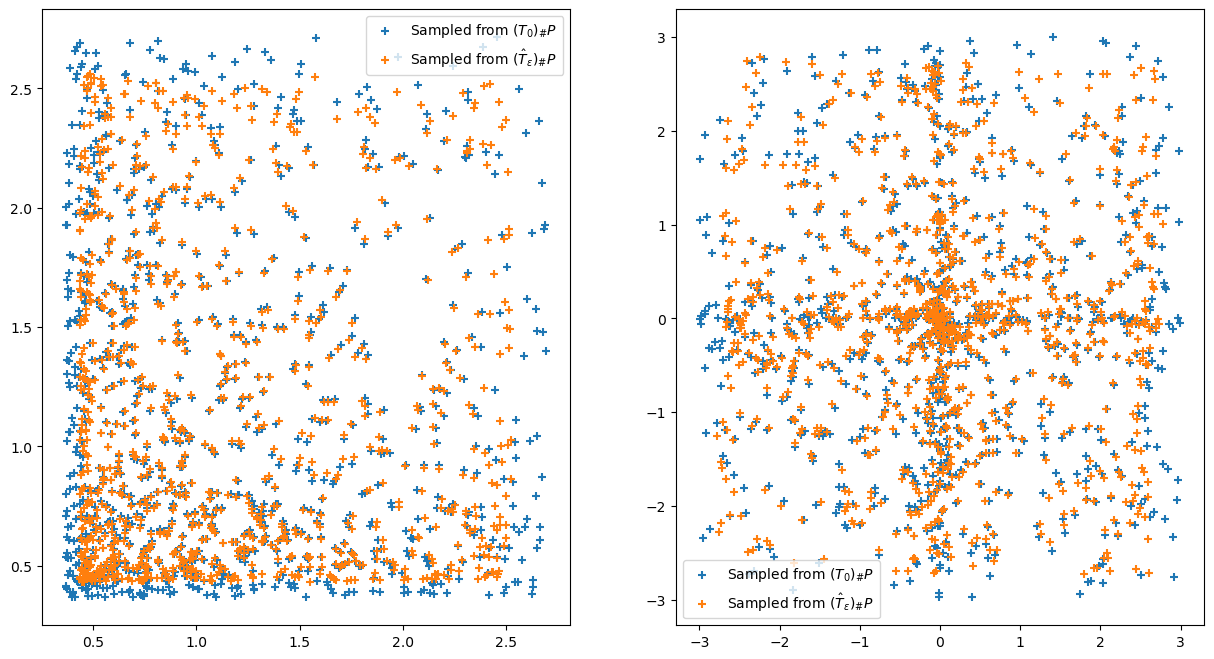

In [6]:
# Plot of the results
fig, axs = plt.subplots(1, 2, figsize=(15,8), sharey=False)

axs[0].scatter(y_test_1[:, 0], y_test_1[:, 1], marker="+", label="Sampled from $(T_0)_{\#}P$")
axs[0].scatter(y_hat_1[:, 0], y_hat_1[:, 1], marker="+", label="Sampled from $(\hat{T}_{\epsilon})_{\#}P$")

axs[1].scatter(y_test_2[:, 0], y_test_2[:, 1], marker="+", label="Sampled from $(T_0)_{\#}P$")
axs[1].scatter(y_hat_2[:, 0], y_hat_2[:, 1], marker="+", label="Sampled from $(\hat{T}_{\epsilon})_{\#}P$")

axs[0].legend()
axs[1].legend()

plt.show()

## Statistical properties

The main results of the estimator is that, under certains conditions, the mean squared error (MSE) between $\hat{T}_\epsilon$ and $T_0$ can be bounded as follow (Theorems 3 and 4):

$$ \mathbb{E}\|\hat{T} - T_0\|_{L^2(P)}^2 \lesssim (1 + I_0(P, Q)) n^{- \frac{(\bar \alpha + 1)}{2(d' + \bar{\alpha} + 1)}} \log n\ $$

with $d' = 2 \lceil{d/2}\rceil$ and $\bar \alpha = \alpha \wedge 3$, $\alpha \in (1,3]$. This inequality is a special case of another one which takes in account $\varepsilon$ :

$$\mathbb E \|T_{\varepsilon, n} - T_0\|_{L^2(P)}^2 \lesssim \varepsilon^{1-d'/2} \log(n) n^{-1/2} + \varepsilon^{(\bar \alpha + 1)/2} + \varepsilon^2 I_0(P, Q)$$

$I_0$ is the integrated Fisher information between P and Q.

We will illustrate these two inequalities varying $n$ and $\varepsilon$ and choosing $T_0(x) = 3 x^2 \text{sign}(x)$.

In [7]:
# Variation accross number of datapoints
n_samples_test = 2048
dims = [2, 5, 10]
eps = 0.05
n_samples = np.logspace(1,3,9)
mses = np.zeros((len(dims), len(n_samples)))

for i, dim in enumerate(dims) :
    for j,n_ in enumerate(n_samples) :
        n_ = int(n_)
        rng = jax.random.PRNGKey(dim)
        rng, *rngs = jax.random.split(rng, 3)
        
        x_train = jax.random.uniform(rngs[0], (n_, dim), minval=-1, maxval=1)
        y_train = 3 * x_train**2 * jnp.sign(x_train)

        x_test = jax.random.uniform(rngs[1], (n_samples_test, dim), minval=-1, maxval=1)
        y_test = 3 * x_test**2 * jnp.sign(x_test)

        entropic_map = estimator_map(x_train, y_train, epsilon=eps)
        y_hat = entropic_map(x_test)

        mses[i, j] = jnp.linalg.norm(y_test - y_hat) ** 2 / n_samples_test

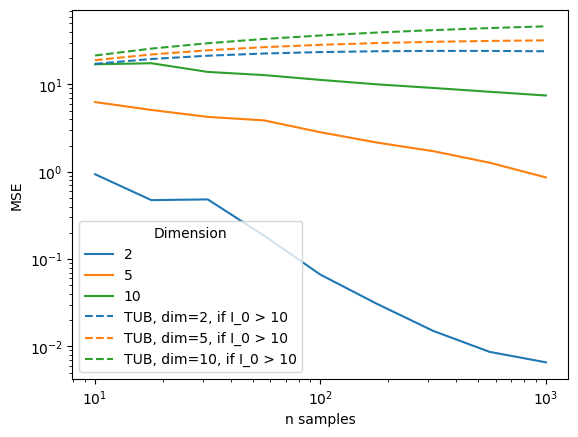

In [8]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(len(mses)) :
    plt.plot(n_samples, mses[i], label=dims[i], color=colors[i])

for i in range(len(mses)) :
    x = n_samples
    y = np.apply_along_axis(lambda x : (1+10) * x**(-(1+1)/(2*(2*(dims[i]//2 + 1) + 1 + 1))) * np.log(x),axis=0,arr=x)
    plt.plot(x, y, label=f'TUB, dim={dims[i]}, if I_0 > 10', color=colors[i], linestyle='--')

plt.xlabel
plt.xscale("log")
plt.yscale("log")
plt.xlabel("n samples")
plt.ylabel("MSE")
plt.legend(title="Dimension")
plt.rcParams["figure.figsize"] = (7,7)
plt.show()

As we can see, under the hypothesis of $I_0>10$, which we don't compute here, the theorical upper bound of Theorem 3 is respected

In [9]:
#Variation accross epsilon
n_samples_test = 1024  # number of samples in MSE estimation
dim = 10 #We choose 10 because as seen above, the log mse vary less according to n_samples with this dimension
n = 1024
epsilons = np.logspace(-2, 0, 15)
mses = []

for j, eps in enumerate(epsilons):
    rng = jax.random.PRNGKey(j)
    rng, *rngs = jax.random.split(rng, 3)
    
    x_train = jax.random.uniform(rngs[0], (n, dim), minval=-1, maxval=1)
    y_train = 3 * x_train**2 * jnp.sign(x_train)

    x_test = jax.random.uniform(rngs[1], (n_samples_test, dim), minval=-1, maxval=1)
    y_test = 3 * x_test**2 * jnp.sign(x_test)

    entropic_map = estimator_map(x_train, y_train, epsilon=eps)
    y_hat = entropic_map(x_test)

    mses.append(jnp.linalg.norm(y_test - y_hat) ** 2 / n_samples_test)

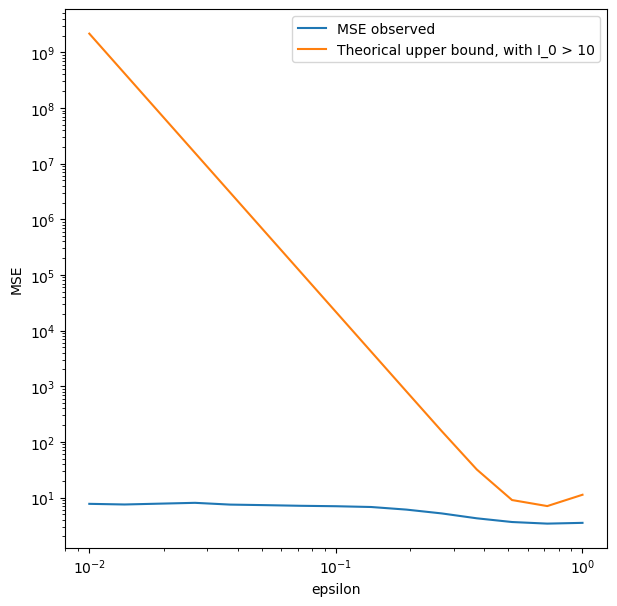

In [10]:
plt.plot(epsilons, mses, label='MSE observed')
y = np.apply_along_axis(lambda x : x**(1-(10//2+1))*np.log(n)*n**(-.5) + x + 10* x**2, axis=0, arr=epsilons)
plt.plot(epsilons,y,label='Theorical upper bound, with I_0 > 10')

plt.xlabel
plt.xscale("log")
plt.yscale("log")
plt.xlabel("epsilon")
plt.ylabel("MSE")
plt.legend()
plt.rcParams["figure.figsize"] = (7,7)
plt.show()

With the same hypothesis $I_0>10$, the polynomial function in $\varepsilon$ depicted in the Theorem 4 as upper bound is also respected

## Example on MNIST and USPS for domain adaptation

Let's place ourselves in the cas where we have two dataset A and B with features in the same space $\mathcal{X}$ and labels in $\mathcal{Y}$. We want to be able to use models on datas from B, such as label classification but trained on datas from A. The issue of domain shifting can be encountered, characterized by different distribution over the features between the domains, ie $p_A(X) \neq p_B(X)$ but same marginal distribution of the labels, ie $p_A(Y|X) = p_B(Y|X)$. We will then use the estimated transport map to reduce this shift and classify efficiently unlabelled data from B.

The source domain will be MNIST Dataset and USPS Dataset will be target domain.

### Loading packages

In [11]:
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100, SVHN, MNIST, EMNIST, SEMEION, USPS
import torchvision.transforms as T
from torch.utils.data import DataLoader

## Sklearn
from sklearn.manifold import TSNE

DATASET_PATH = "./data"

c:\Users\Ambroise\anaconda3\envs\deepl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Loading

In [12]:
MNIST_train_dataset = MNIST(root=DATASET_PATH, train= True, download=True)
mnist_train_data = MNIST_train_dataset.data[:6000].numpy()/255 #Since the USPS dataset has only 7291 images, we keep only the 6000 first of each dataset
mnist_train_labels = jnp.array(MNIST_train_dataset.targets)[:6000]

MNIST_test_dataset = MNIST(root=DATASET_PATH, train= False, download=True)
mnist_test_data = MNIST_test_dataset.data[:2000].numpy()/255 
mnist_test_labels = jnp.array(MNIST_test_dataset.targets)[:2000]

USPS_train_dataset = USPS(root=DATASET_PATH, train= True, download=True)
USPS_test_dataset = USPS(root=DATASET_PATH, train= False, download=True)

usps_train_data = USPS_train_dataset.data[:6000]
usps_train_data = np.array([np.pad(usps_train_data[i], 6, mode='constant', constant_values=0)/255 for i in range(len(usps_train_data))]) #MNIST Data are 28x28 so we need to pad the datas from USPS which are 16*16
usps_train_labels = jnp.array(USPS_train_dataset.targets)[:6000]

usps_test_data = USPS_test_dataset.data
usps_test_data = np.array([np.pad(usps_test_data[i], 6, mode='constant', constant_values=0)/255 for i in range(len(usps_test_data))])
usps_test_labels = jnp.array(USPS_test_dataset.targets)

In [13]:
mnist_train_xdata = np.reshape(mnist_train_data, (len(mnist_train_data), 28*28))
mnist_test_xdata = np.reshape(mnist_test_data, (len(mnist_test_data), 28*28))
usps_train_xdata = np.reshape(usps_train_data, (len(usps_train_data), 28*28))
usps_test_xdata = np.reshape(usps_test_data, (len(usps_test_data), 28*28))

### Examples of datas

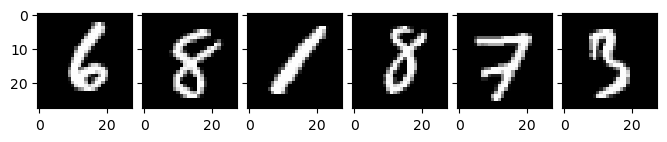

In [32]:
from mpl_toolkits.axes_grid1 import ImageGrid
#Examples from MNIST
NUM_IMAGES=6
MNIST_grid = mnist_train_data[np.random.randint(0,len(mnist_test_data),12),:,:]

fig = plt.figure(figsize=(8,8))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 6),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, MNIST_grid):
    # Iterating over the grid returns the Axes.
    ax.imshow(im,cmap='gray')
plt.show()

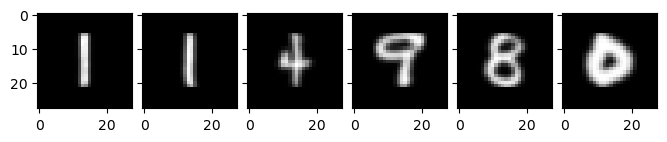

In [35]:
#Examples from USPS
NUM_IMAGES=6
USPS_grid = usps_train_data[np.random.randint(0,len(mnist_test_data),12),:,:]

fig = plt.figure(figsize=(8,8))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 6),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, USPS_grid):
    # Iterating over the grid returns the Axes.
    ax.imshow(im,cmap='gray')
plt.show()

### Visualization of the domain shift

We use TSNE embedding from sklearn to visualize domain shift between MNIST and USPS datas

In [14]:
xtot=np.concatenate((mnist_train_xdata, usps_train_xdata),axis=0)

xp=TSNE().fit_transform(xtot)
xpMNIST=xp[:6000]
xpUSPS=xp[6000:]

Text(0.5, 1.0, 'TSNE Embedding of the data')

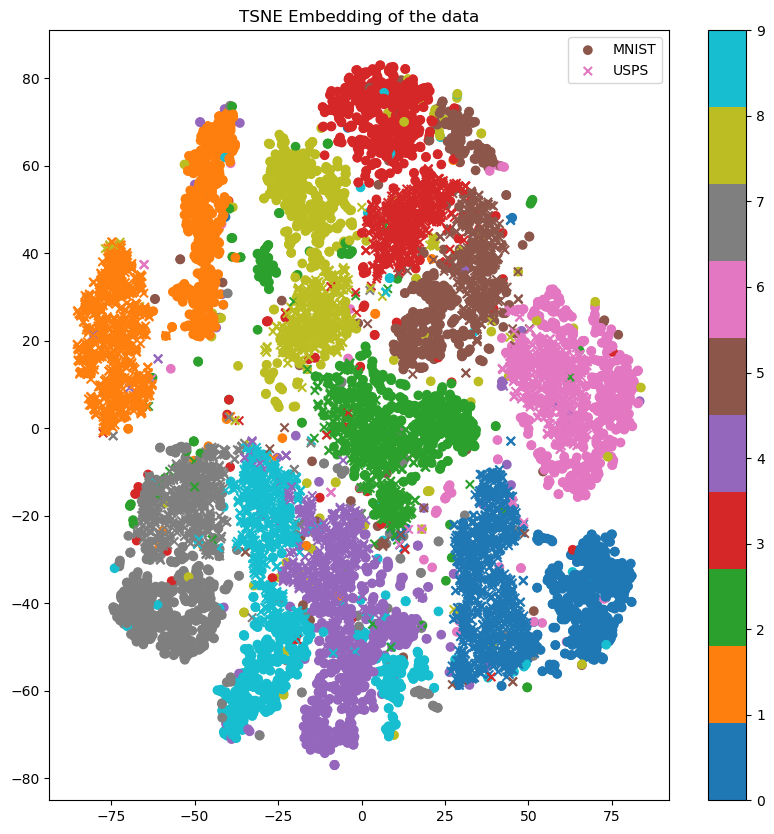

In [15]:
plt.figure(3,(10,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=mnist_train_labels,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=usps_train_labels,marker='x',cmap='tab10',label='USPS')
plt.legend()
plt.colorbar()
plt.title('TSNE Embedding of the data')

As we can see, the embeddings of the datas are close from a dataset to another but not mingled. Let's see now the performance of simple classification model for label attribution when we only train on MNIST datas.

In [16]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=500,).fit(mnist_train_xdata, mnist_train_labels)

print(clf.score(mnist_test_xdata, mnist_test_labels))
print(clf.score(usps_test_xdata, usps_test_labels))

0.875
0.5575485799701047


Let's compute the transport map from USPS toward MNIST datas

In [17]:
transport_map = estimator_map(usps_train_xdata, mnist_train_xdata, epsilon=0.05)

In [24]:
xtot=np.concatenate((mnist_train_xdata, transport_map(usps_train_xdata)),axis=0)

xp=TSNE().fit_transform(xtot)
xpMNIST=xp[:6000]
xpUSPS=xp[6000:]

Text(0.5, 1.0, 'TSNE Embedding of the data')

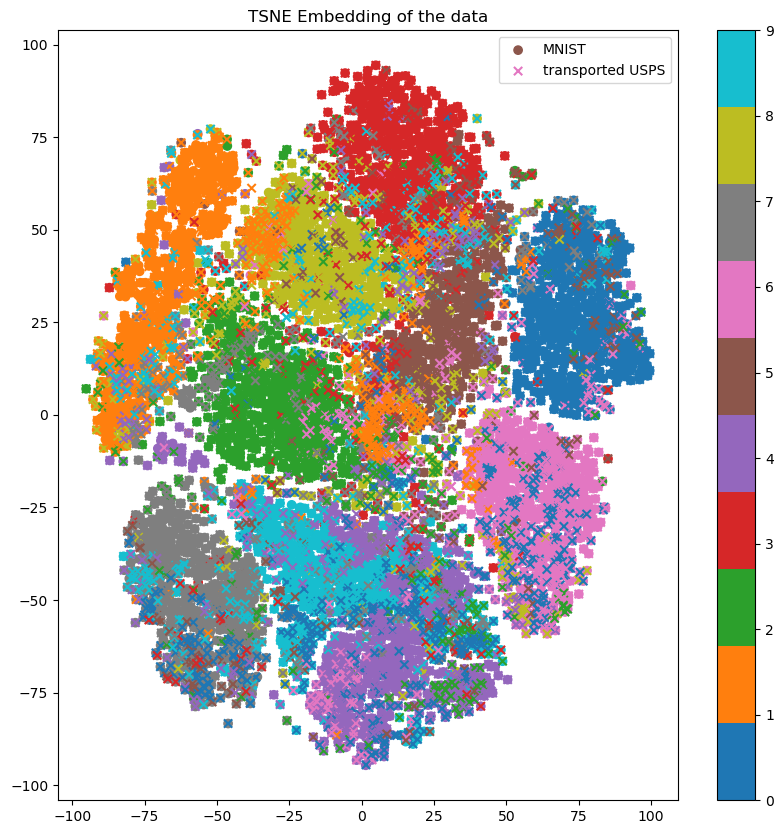

In [36]:
plt.figure(3,(10,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=mnist_train_labels,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=usps_train_labels,marker='x',cmap='tab10',label='transported USPS')
plt.legend()
plt.colorbar()
plt.title('TSNE Embedding of the data')

The domain shift is not as visible as before but many datapoints are wrongly transported which may not improved the perfomances of the predictions as much as wanted

In [18]:
print(clf.score(transport_map(usps_test_xdata), usps_test_labels))

0.5650224215246636


### Visualization of transported images

Let's now visualize the transport from images from USPS to the MNIST domain.

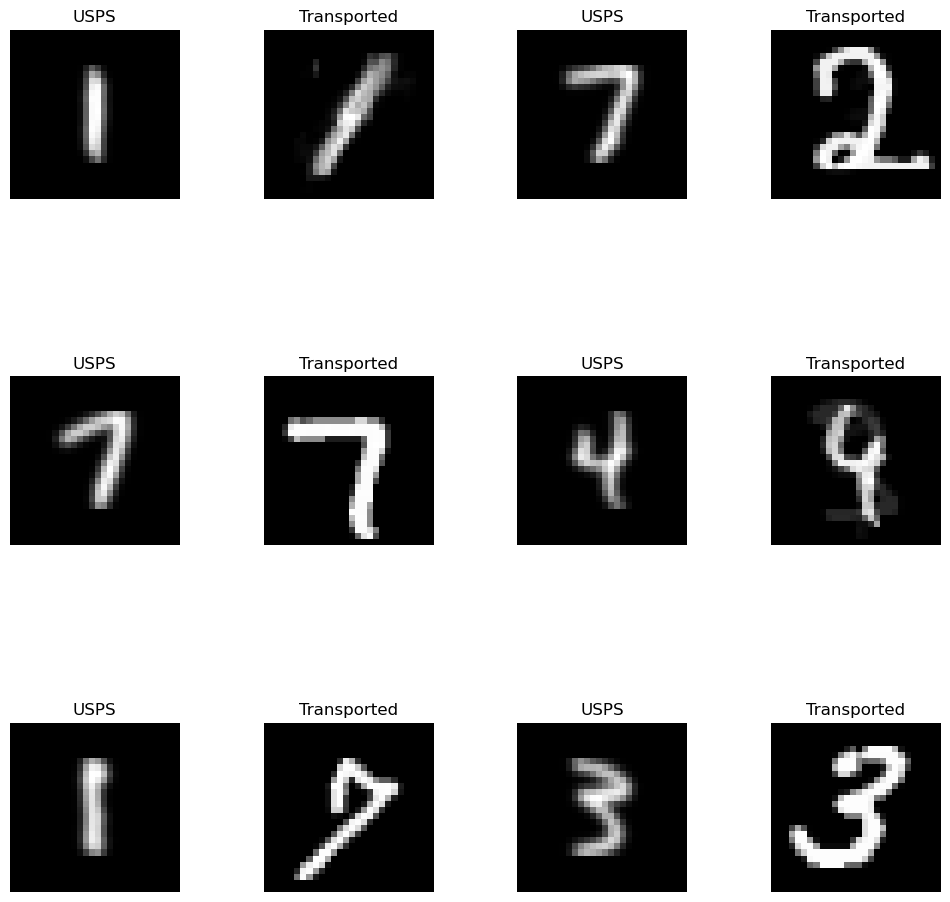

In [66]:
usps_test_transported = transport_map(usps_test_xdata)
random_idx = np.random.randint(0,len(usps_test_xdata),6)

fig, axes = plt.subplots(3, 4, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
    
for i, j in enumerate(random_idx):
    ax = axes[(2*(i+1)) // 5, (2*i) % 4]
    ax.imshow(usps_test_xdata[j].reshape(28,28),cmap='gray')
    ax.axis('off')
    ax.set_title("USPS")
    
    ax = axes[(2*(i+1)) // 5, ((2*i) % 4) + 1]
    ax.imshow(usps_test_transported[j].reshape(28,28),cmap='gray')
    ax.axis('off')
    ax.set_title("Transported")

plt.show()